In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


### Train Data exploration and visualization

In [2]:
df_train = pd.read_csv('train.csv')
df_train.shape

(404290, 6)

In [3]:

# df_train = df_train.loc[np.random.random_integers(0, len(df_train), 10000)]
# len(df_train)

In [4]:
qids = pd.Series(df_train['qid1'].tolist()+df_train['qid2'].tolist())

In [5]:
unique_qid = set(qids)
unique_qsts = len(unique_qid)
qs_morethan_onetime= sum(qids.value_counts()>1)
qs_morethan_onetime

111780

In [6]:
  df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
#check how many questions with any null value
nan_count = df_train[df_train.isnull().any(1)]
nan_count

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [8]:
df_train[df_train.isnull().any(1)]
df_train = df_train.fillna('') #Fill null values with '' string

In [9]:
#Re-check how many questions with any null value
nan_count = df_train[df_train.isnull().any(1)]
nan_count #Finally the we found the question with no null values 

,id,qid1,qid2,question1,question2,is_duplicate


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [11]:
df_train.groupby("is_duplicate")['id'].count() #count the number of 'duplicate' and 'non-duplicate' question

is_duplicate
0    255027
1    149263
Name: id, dtype: int64

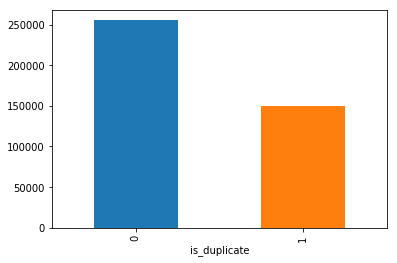

In [12]:
df_train.groupby("is_duplicate")['id'].count().plot.bar() #plot the graph for the above data

In [13]:
is_duplicate0 = len(df_train[df_train['is_duplicate']==0])
is_duplicate0/len(df_train)
print("Percentage of non-Duplicate Questions: %d percentage"%((is_duplicate0/len(df_train))*100))

Percentage of non-Duplicate Questions: 63 percentage


In [14]:
is_duplicate1 = len(df_train[df_train['is_duplicate']==1])
is_duplicate1/len(df_train)

print("Percentage of Duplicate Questions: %d percentage"%((is_duplicate1/len(df_train))*100))

Percentage of Duplicate Questions: 36 percentage


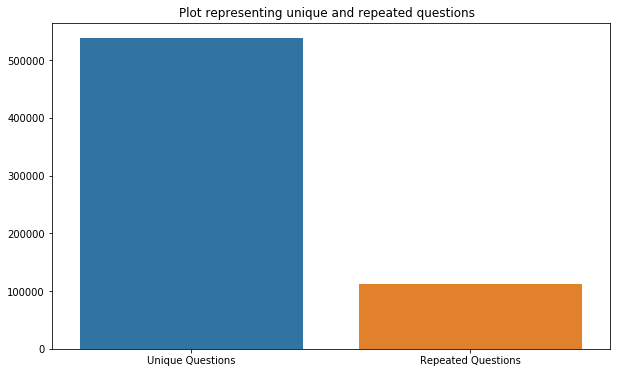

In [15]:
x = ["Unique Questions" , "Repeated Questions"]
y =  [unique_qsts , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [16]:
#Check whether there are any repeated pair of questions
pair_duplicates  = df_train[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print('Total Number of pair_duplicates groups: ',pair_duplicates.shape[0])
print('Total Number of row: ',df_train.shape[0]) #If both count are equal then there are no duplicates
print("Total duplicate pairs: ",(df_train.shape[0] - pair_duplicates.shape[0]))

Total Number of pair_duplicates groups:  404290
Total Number of row:  404290
Total duplicate pairs:  0


### Overall info about train Data

In [17]:
df_test = pd.read_csv('test.csv')

In [18]:
print('Total number of question pairs in training dataset: ', len(df_train))
print('total number of question pairs to predict is_duplicate: ', len(df_test))
print('Total number of unique questions in training dataset: ', len(unique_qid))
print("In Train dataset: ")
print('Total percentage of is_duplicate=0: ', round((is_duplicate0/(is_duplicate0+is_duplicate1))*100, 2), "%")
print('Total percentage of is_duplicate=1: ', round((is_duplicate1/(is_duplicate0+is_duplicate1))*100, 2), "%")

Total number of question pairs in training dataset:  404290
total number of question pairs to predict is_duplicate:  2345796
Total number of unique questions in training dataset:  537933
In Train dataset: 
Total percentage of is_duplicate=0:  63.08 %
Total percentage of is_duplicate=1:  36.92 %


###  Feature extraction 

1. **q1_len** = Length of Question-1
2. **q2_len** = Length of Question-2
3. **q1_no_words** = Number of words in Question-1
4. **q2_no_words** = Number of words in Question-2
5. **total_uni_words** = Total number of unique words in Question-1 and Question-2, Combine and find unique.
6. **common_words** = Total number of common words in both Question-1 and Question-2
7. **word_share** = Total number of words share(common_words/total_words)
8. **total_words** = Total number of words unique words in Question-1 and Question-2, find Unique in each and add them.

In [19]:
# def total_uni_words(row):
# #     print(row['question1'])
# df_train['total_uni_words'] = df_train.apply(total_uni_words, axis=1)

In [20]:
df_train['q1_len'] = df_train['question1'].str.len()
df_train['q2_len'] = df_train['question2'].str.len()
df_train['q1_no_words'] = df_train['question1'].apply(lambda row: len(row.split()))
df_train['q2_no_words'] = df_train['question2'].apply(lambda row: len(row.split()))

df_train['q1_uni'] = df_train.apply(lambda row: len(set(row['question1'].lower().strip().split())), axis=1)
df_train['q2_uni'] = df_train.apply(lambda row: len(set(row['question2'].lower().strip().split())), axis=1)
df_train['avg_uwc'] = df_train.apply(lambda row: (row['q1_uni']+row['q2_uni'])/2.0, axis=1)
def total_uni_words(row):
    q1_w = row['question1'].lower().strip().split()
    q2_w = row['question2'].lower().strip().split()
    total_w = len(set(q1_w + q2_w))
    return total_w
df_train['total_uni_words'] = df_train.apply(total_uni_words, axis=1)

def total_words(row):
    q1_w = set(row['question1'].lower().strip().split())
    q2_w = set(row['question2'].lower().strip().split())
    total_w = len(q1_w)+ len(q2_w)
    return total_w

df_train['total_words'] = df_train.apply(total_words, axis=1)

def common_words(row):
    q1_w = set(row['question1'].lower().strip().split())
    q2_w = set(row['question2'].lower().strip().split())
    common_w = len(q1_w.intersection(q2_w)) #find common between two sets
#     x = set(["a","b","c","d"])
#     y = set(["c","d", 'f'])
#     print( y.intersection(x) )
#     outPut: {'c', 'd'}
    return common_w
df_train['common_words'] = df_train.apply(common_words, axis=1)   

def word_share(row):
    w_share = row['common_words']/row['total_words']
    return 1.0*w_share
    
df_train['word_share'] = df_train.apply(word_share, axis=1)   





df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_no_words,q2_no_words,q1_uni,q2_uni,avg_uwc,total_uni_words,total_words,common_words,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,12,11,11.5,13,23,10,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,8,12,10.0,16,20,4,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,14,10,12.0,20,24,4,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,10,9,9.5,19,19,0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,13,7,10.0,18,20,2,0.100000


\\cifs-ecs.cs.odu.edu\Grad\cmuthyal\win_user_profile\AppData\Python\Python36\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


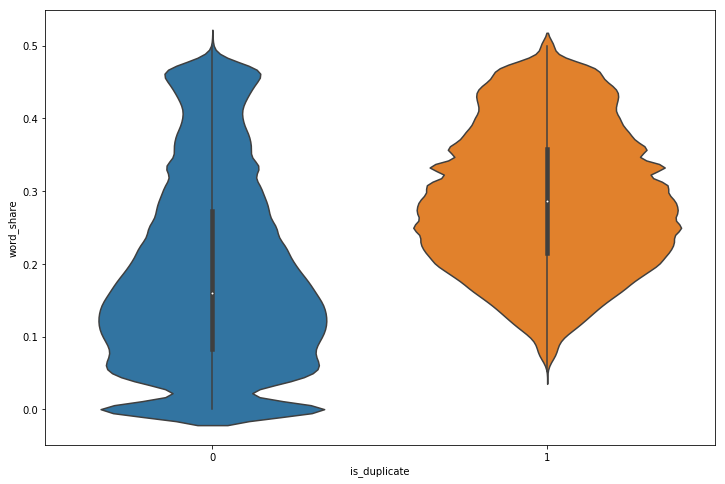

In [21]:
plt.figure(figsize=(12, 8))

sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df_train)

\\cifs-ecs.cs.odu.edu\Grad\cmuthyal\win_user_profile\AppData\Python\Python36\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


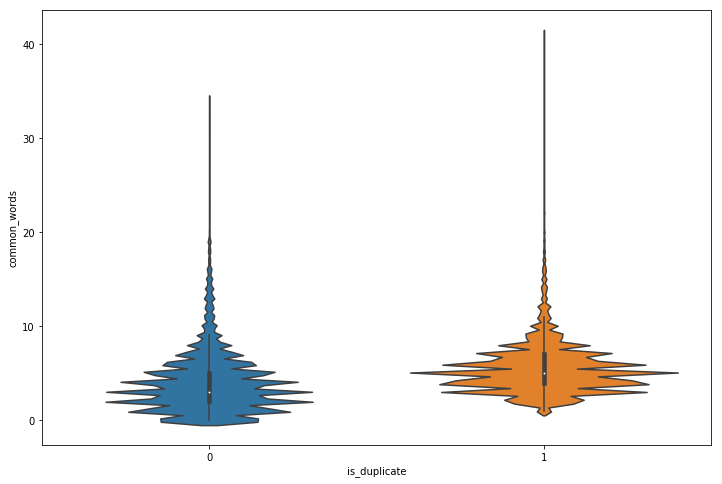

In [22]:
plt.figure(figsize=(12, 8))

sns.violinplot(x = 'is_duplicate', y = 'common_words', data = df_train)

\\cifs-ecs.cs.odu.edu\Grad\cmuthyal\win_user_profile\AppData\Python\Python36\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


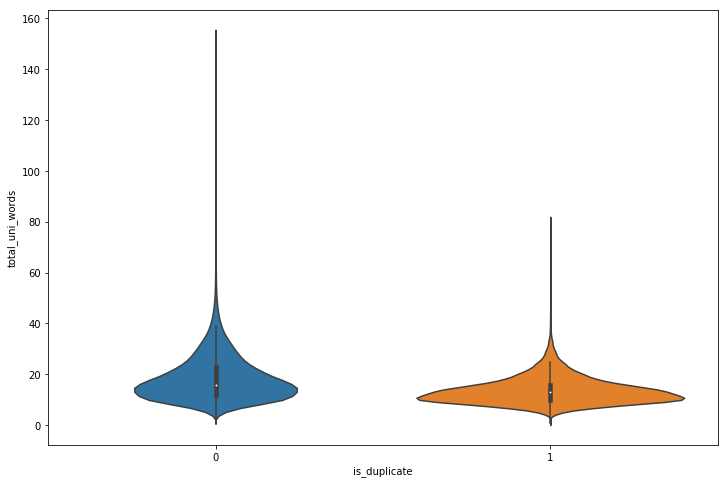

In [23]:
plt.figure(figsize=(12, 8))

sns.violinplot(x = 'is_duplicate', y = 'total_uni_words', data = df_train)

In [24]:
#Some Analysis of extracted feature

print("Shortest length of the question in Question-1: %d"%min(df_train['q1_no_words']))
print("Shortest length of the question in Question-2:  %d"%min(df_train['q2_no_words']))

Shortest length of the question in Question-1: 0
Shortest length of the question in Question-2:  0


In [25]:
df_train = df_train[df_train['q1_no_words']>0]
df_train = df_train[df_train['q2_no_words']>0]
print("Shortest length of the question in Question-1: %d"%min(df_train['q1_no_words']))
print("Shortest length of the question in Question-2:  %d"%min(df_train['q2_no_words']))

Shortest length of the question in Question-1: 1
Shortest length of the question in Question-2:  1


In [26]:
# Now find how many number of questions with min length
print("Total number of question with min length in Question-1: ",df_train[df_train['q1_no_words']==1].shape[0])
print("Total number of question with min length in Question-2: ",df_train[df_train['q2_no_words']==1].shape[0])

Total number of question with min length in Question-1:  69
Total number of question with min length in Question-2:  25


### PreProcessing the text

In [27]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
stop_words = stopwords.words("english")

In [28]:

def preProcess(x):
    x = str(x).lower()
    x = x.replace("won't", "will not")\
            .replace("cannot", "can not")\
            .replace("can't", "can not")\
            .replace("n't", " not")\
            .replace("what's", "what is")\
            .replace("it's", "it is")\
            .replace("i'm", "i am")\
            .replace("'re", " are")\
            .replace("%", " percent ")\
            .replace("€", " euro ")\
            .replace("'ll", " will")\
            .replace(",000,000", "m")\
            .replace(",000", "k")
#     x = re.sub(r"([0-9]+)000000", r"\1m", x)
#     x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    if type(x) == type(''):
        x = porter.stem(x)
        temp = BeautifulSoup(x)
        x = temp.get_text()
#     print(x)
    return x

In [29]:
df_train['question1'] = df_train["question1"].fillna("").apply(preProcess)

C:\Users\cmuthyal\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\cmuthyal\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
C:\Users\cmuthyal\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [30]:
df_train['question1'].head()

0    what is the step by step guide to invest in sh...
1    what is the story of kohinoor (koh-i-noor) dia...
2    how can i increase the speed of my internet co...
3    why am i mentally very lonely? how can i solve...
4    which one dissolve in water quikly sugar, salt...
Name: question1, dtype: object

In [31]:
df_train['question2'] = df_train["question2"].fillna("").apply(preProcess)

C:\Users\cmuthyal\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\cmuthyal\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [32]:
df_train['avg_len'] = df_train.apply(lambda row: (row['q1_len']+row['q2_len'])/2.0 , axis=1)
df_train['cwc_min'] = df_train.apply(lambda row: row['common_words']/(min(row['q1_len'], row['q2_len'])) , axis=1)
df_train['cwc_max'] = df_train.apply(lambda row: row['common_words']/(max(row['q1_len'], row['q2_len'])) , axis=1)
df_train['is_fw_same'] = df_train.apply(lambda row: (row['question1'].lower().strip().split()[0] == row['question2'].lower().strip().split()[0]) , axis=1)
df_train['is_lw_same'] = df_train.apply(lambda row: (row['question1'].lower().strip().split()[-1] == row['question2'].lower().strip().split()[-1]) , axis=1)

df_train['cwc_min'] = df_train.apply(lambda row: row['common_words']/(min(row['q1_len'], row['q2_len'])) , axis=1)
df_train['cwc_max'] = df_train.apply(lambda row: row['common_words']/(min(row['q1_len'], row['q2_len'])) , axis=1)

In [33]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_no_words,q2_no_words,...,avg_uwc,total_uni_words,total_words,common_words,word_share,avg_len,cwc_min,cwc_max,is_fw_same,is_lw_same
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,14,12,...,11.5,13,23,10,0.434783,61.5,0.175439,0.175439,True,False
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,51,88,8,13,...,10.0,16,20,4,0.200000,69.5,0.078431,0.078431,True,False
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,73,59,14,10,...,12.0,20,24,4,0.166667,66.0,0.067797,0.067797,True,False
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,...,9.5,19,19,0,0.000000,57.5,0.000000,0.000000,False,False
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,76,39,13,7,...,10.0,18,20,2,0.100000,57.5,0.051282,0.051282,True,False


### Feature Extraction from fuzzywuzzy

In [34]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

C:\Users\cmuthyal\AppData\Local\Continuum\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [35]:
'''
Definations

1. Simple Ratio: Compare two sequences and produce the ratio of those two
2. Partial Ratio: Find the max
3. Token Sort Ratio: The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and then joining them back into a string. 
4. Token Set Ratio: we tokenize both strings, but instead of immediately sorting and comparing, we split the tokens into two groups: intersection and remainder. We use those sets to build up a comparison string.
'''


'\nDefinations\n\n1. Simple Ratio: Compare two sequences and produce the ratio of those two\n2. Partial Ratio: Find the max\n3. Token Sort Ratio: The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and then joining them back into a string. \n4. Token Set Ratio: we tokenize both strings, but instead of immediately sorting and comparing, we split the tokens into two groups: intersection and remainder. We use those sets to build up a comparison string.\n'

In [36]:
def fuzzy_features(row):
    simple_ratio = fuzz.ratio(row['question1'],row['question2'])
    partial_ratio =  fuzz.partial_ratio(row['question1'],row['question2'])
    token_sort_ratio = fuzz.token_sort_ratio(row['question1'],row['question2'])
    token_set_ratio =  fuzz.token_set_ratio(row['question1'],row['question2'])
    partial_token_set_ratio = fuzz.partial_token_set_ratio(row['question1'],row['question2'])
    partial_token_sort_ratio = fuzz.partial_token_sort_ratio(row['question1'],row['question2'])
    
    return [simple_ratio, partial_ratio, token_sort_ratio, token_set_ratio, partial_token_set_ratio,partial_token_sort_ratio]

In [37]:
# def fuzzy_simple_ratio(row):
#     temp_ratio = fuzz.ratio(row['question1'],row['question2'])
#     return temp_ratio

In [38]:
# def fuzzy_partial_ratio(row):
#     temp_ratio = fuzz.partial_ratio(row['question1'],row['question2'])
#     return temp_ratio

In [39]:
# def fuzzy_token_sort_ratio(row):
#     temp_ratio = fuzz.token_sort_ratio(row['question1'],row['question2'])
#     return temp_ratio

In [40]:
# def fuzzy_token_set_ratio(row):
#     temp_ratio = fuzz.token_set_ratio(row['question1'],row['question2'])
#     return temp_ratio

In [41]:
# df_train['simple_ratio'] = df_train.apply(fuzzy_simple_ratio, axis=1)

In [42]:
# df_train['partial_ratio'] = df_train.apply(fuzzy_partial_ratio, axis=1)

In [43]:
# df_train['token_sort_ratio'] = df_train.apply(fuzzy_token_sort_ratio, axis=1)

In [44]:
# df_train['token_set_ratio'] = df_train.apply(fuzzy_token_set_ratio, axis=1)

In [45]:
fuzzy_features = df_train.apply(fuzzy_features, axis=1)

In [46]:
from difflib import SequenceMatcher
import math
df_train['difflib_similarity'] = df_train.apply(lambda x: SequenceMatcher(None, str(x['question1']), str(x['question2'])).ratio(), axis=1)

# Compute Jaccard Similarity Score 
def jaccard_similarity_str(row):
    intersection_cardinality = len(set.intersection(*[set(row['question1']), set(row['question2'])]))
    union_cardinality = len(set.union(*[set(row['question1']), set(row['question2'])]))
    return intersection_cardinality/float(union_cardinality)
def cosine_similarity_str(row):
    intersection_cardinality = len(set.intersection(*[set(row['question1']), set(row['question2'])]))
    sqrt_product = math.sqrt(len(row['question1'])) * math.sqrt(len(row['question2']))
    return intersection_cardinality/float(sqrt_product)
df_train['jaccard_similarity_str'] = df_train.apply(jaccard_similarity_str, axis=1)
df_train['cosine_similarity_str'] = df_train.apply(cosine_similarity_str, axis=1)


# jacard_score =  len(common_words)/(len(q1_words) + len(q2_words) - len(common_words))  
# cosine_score = len(common_words)/(pow(len(q1_words),0.5)*pow(len(q2_words),0.5))

In [47]:
# fuzzy_features.values
temp = np.vstack(fuzzy_features.values)
df_train['simple_ratio'] = temp[:,0]
df_train['partial_ratio'] = temp[:,1]
df_train['token_sort_ratio'] = temp[:,2]
df_train['token_set_ratio'] = temp[:,3]
df_train['partial_token_set_ratio'] = temp[:,4]
df_train['partial_token_sort_ratio'] = temp[:,5]

In [48]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_no_words,q2_no_words,...,is_lw_same,difflib_similarity,jaccard_similarity_str,cosine_similarity_str,simple_ratio,partial_ratio,token_sort_ratio,token_set_ratio,partial_token_set_ratio,partial_token_sort_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,14,12,...,False,0.926829,1.000000,0.342381,93,98,93,100,100,88
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,51,88,8,13,...,False,0.661871,0.703704,0.283614,66,75,63,86,100,73
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,73,59,14,10,...,False,0.439394,0.750000,0.274274,44,47,63,63,100,71
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,...,False,0.086957,0.466667,0.245576,9,10,24,28,32,30
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,76,39,13,7,...,False,0.365217,0.653846,0.312255,37,54,47,67,100,67


### Analyzing the extracted features

In [49]:
df_duplicate = df_train[df_train['is_duplicate'] == 1]
df_non_duplicate = df_train[df_train['is_duplicate'] == 0]

In [50]:
duplicate_array = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
non_duplicate_array = np.dstack([df_non_duplicate["question1"], df_non_duplicate["question2"]]).flatten()

In [51]:
text_dulicate = " ".join(duplicate_array)
text_non_dulicate = " ".join(non_duplicate_array)

In [52]:
from wordcloud import WordCloud

Word Cloud for Duplicate Question pairs


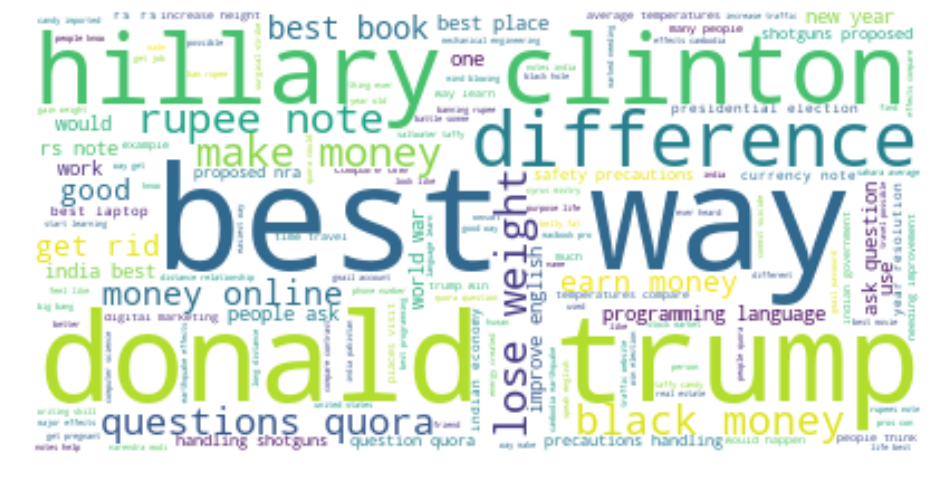

In [53]:
wc = WordCloud(background_color="white", max_words=len(text_dulicate), stopwords=stop_words)
wc.generate(text_dulicate)
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(16, 9))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non Duplicate Question pairs


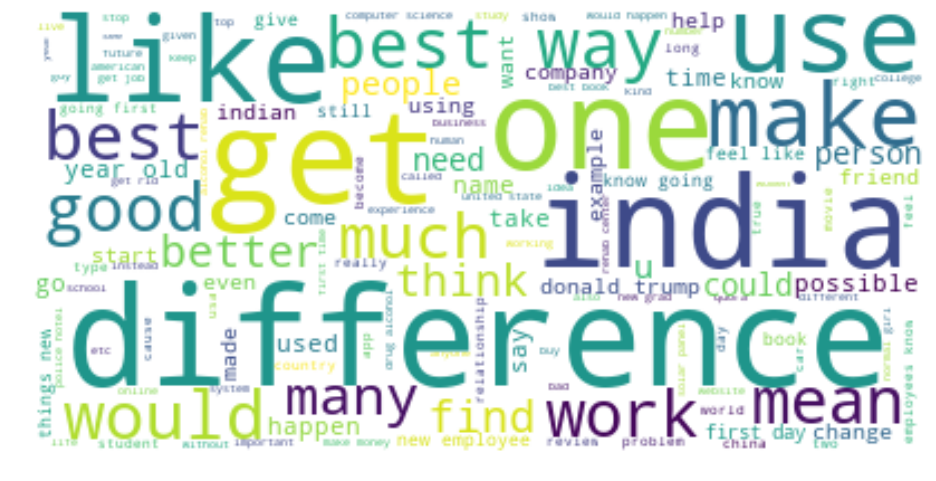

In [54]:
wc = WordCloud(background_color="white", max_words=len(text_non_dulicate), stopwords=stop_words)
wc.generate(text_non_dulicate)
print ("Word Cloud for non Duplicate Question pairs")
plt.figure(figsize=(16, 9))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [55]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
X = MinMaxScaler().fit_transform(df_train[['q1_len', 'q2_len', 'q1_no_words', 'difflib_similarity', 'q2_no_words', 'total_uni_words', 'total_words', 'common_words', 'word_share', 'simple_ratio', 'partial_ratio', 'token_sort_ratio', 'token_set_ratio','partial_token_set_ratio','partial_token_sort_ratio']])
y = df_train['is_duplicate'].values

\\cifs-ecs.cs.odu.edu\Grad\cmuthyal\win_user_profile\AppData\Python\Python36\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [56]:
X

array([[0.10450161, 0.04794521, 0.10483871, ..., 1.        , 1.        ,
        0.88      ],
       [0.08038585, 0.0744863 , 0.05645161, ..., 0.86      , 1.        ,
        0.73      ],
       [0.11575563, 0.04965753, 0.10483871, ..., 0.63      , 1.        ,
        0.71      ],
       ...,
       [0.02572347, 0.01369863, 0.02419355, ..., 0.86      , 1.        ,
        0.75      ],
       [0.14951768, 0.10787671, 0.12903226, ..., 0.37      , 1.        ,
        0.36      ],
       [0.05787781, 0.03767123, 0.05645161, ..., 1.        , 1.        ,
        0.92      ]])

In [57]:
# tsne2d = TSNE(
#     n_components=2,
#     init='random', # pca
#     random_state=101,
#     method='barnes_hut',
#     n_iter=1000,
#     verbose=2,
#     angle=0.5
# ).fit_transform(X)

In [58]:
# type(tsne2d)

In [59]:
# df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# # draw the plot in appropriate place in the grid
# sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
# plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
# plt.show()

In [60]:
# from sklearn.manifold import TSNE
# tsne3d = TSNE(
#     n_components=3,
#     init='random', # pca
#     random_state=101,
#     method='barnes_hut',
#     n_iter=1000,
#     verbose=2,
#     angle=0.5
# ).fit_transform(X)

In [61]:
# import plotly.graph_objs as go
# import plotly.offline as py
# trace1 = go.Scatter3d(
#     x=tsne3d[:,0],
#     y=tsne3d[:,1],
#     z=tsne3d[:,2],
#     mode='markers',
#     marker=dict(
#         sizemode='diameter',
#         color = y,
#         colorscale = 'Portland',
#         colorbar = dict(title = 'duplicate'),
#         line=dict(color='rgb(255, 255, 255)'),
#         opacity=0.75
#     )
# )

# data=[trace1]
# layout=dict(height=800, width=800, title='3d embedding with engineered features')
# fig=dict(data=data, layout=layout)
# py.iplot(fig, filename='3DBubble')

In [62]:

# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
# ['id', 'qid1', 'qid2', 'question1', 'question2']
cols = list(df_train.columns)
for i in cols:
    if i not in ['id', 'qid1', 'qid2', 'question1', 'question2']:
        df_train[i] = df_train[i].apply(pd.to_numeric)
        print(i)

is_duplicate
q1_len
q2_len
q1_no_words
q2_no_words
q1_uni
q2_uni
avg_uwc
total_uni_words
total_words
common_words
word_share
avg_len
cwc_min
cwc_max
is_fw_same
is_lw_same
difflib_similarity
jaccard_similarity_str
cosine_similarity_str
simple_ratio
partial_ratio
token_sort_ratio
token_set_ratio
partial_token_set_ratio
partial_token_sort_ratio


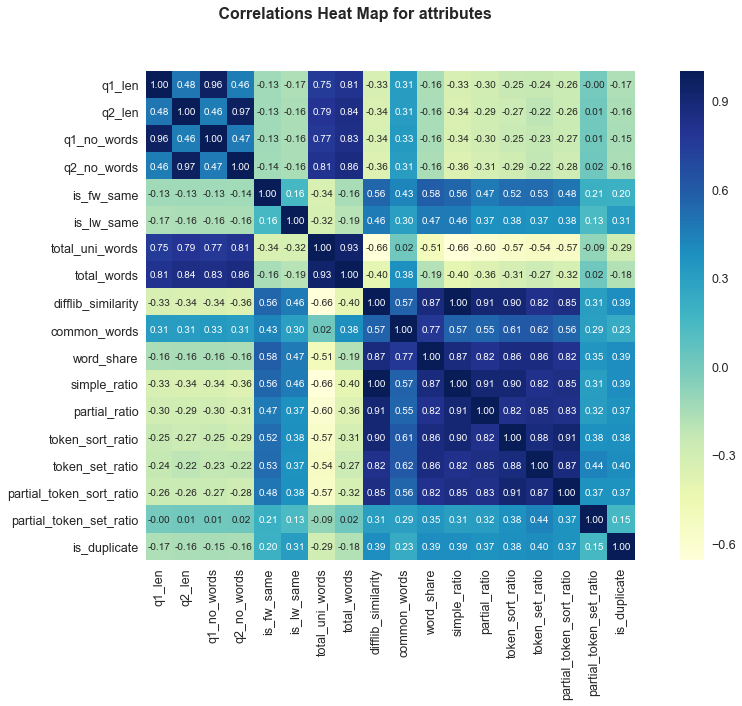

In [63]:
import seaborn as sns
cor = df_train[['q1_len', 'q2_len', 'q1_no_words', 'q2_no_words','is_fw_same','is_lw_same', 'total_uni_words', 'total_words','difflib_similarity', 'common_words', 'word_share', 'simple_ratio', 'partial_ratio', 'token_sort_ratio', 'token_set_ratio','partial_token_sort_ratio','partial_token_set_ratio', 'is_duplicate']].corr()
sns.set(font_scale=1.25)
plt.figure(figsize=(16,9))
hm = sns.heatmap(cor, cbar=True, annot=True, square=True,cmap="YlGnBu",
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=list(cor.columns), xticklabels=list(cor.columns))
plt.suptitle(' Correlations Heat Map for attributes', fontsize=16, fontweight='bold')
plt.show()


# # ref: https://www.kaggle.com/fg1983/data-exploration-and-price-prediction-house-sales

In [64]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_no_words,q2_no_words,...,is_lw_same,difflib_similarity,jaccard_similarity_str,cosine_similarity_str,simple_ratio,partial_ratio,token_sort_ratio,token_set_ratio,partial_token_set_ratio,partial_token_sort_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,14,12,...,False,0.926829,1.000000,0.342381,93,98,93,100,100,88
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,51,88,8,13,...,False,0.661871,0.703704,0.283614,66,75,63,86,100,73
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,73,59,14,10,...,False,0.439394,0.750000,0.274274,44,47,63,63,100,71
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,...,False,0.086957,0.466667,0.245576,9,10,24,28,32,30
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,76,39,13,7,...,False,0.365217,0.653846,0.312255,37,54,47,67,100,67


### Random train test split

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score
# define tfidf vectorizer 
tfidf = TfidfVectorizer(analyzer = 'word',token_pattern=r'\w{1,}',
                        ngram_range=(1,2),use_idf=1,smooth_idf=1,sublinear_tf=1,
                        stop_words = 'english',
                        lowercase = True,
                        max_features = None,
                        norm = 'l1')

In [66]:
# text_dulicate
s1 = pd.Series(df_train['question1'].tolist())
s2 = pd.Series(df_train['question2'].tolist())
BagOfWords = pd.concat([s1, s2])

In [67]:
tfidf.fit(BagOfWords)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l1', preprocessor=None, smooth_idf=1,
        stop_words='english', strip_accents=None, sublinear_tf=1,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=1,
        vocabulary=None)

In [68]:
train_q1_tfidf = tfidf.transform(df_train['question1'])
train_q2_tfidf = tfidf.transform(df_train['question2'])

In [69]:
df_train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_len', 'q2_len', 'q1_no_words', 'q2_no_words', 'q1_uni', 'q2_uni',
       'avg_uwc', 'total_uni_words', 'total_words', 'common_words',
       'word_share', 'avg_len', 'cwc_min', 'cwc_max', 'is_fw_same',
       'is_lw_same', 'difflib_similarity', 'jaccard_similarity_str',
       'cosine_similarity_str', 'simple_ratio', 'partial_ratio',
       'token_sort_ratio', 'token_set_ratio', 'partial_token_set_ratio',
       'partial_token_sort_ratio'],
      dtype='object')

In [70]:
# X = abs(train_q1_tfidf - train_q2_tfidf)
X= df_train[[\
       'q1_len', 'q2_len', 'q1_no_words', 'q2_no_words', 'q1_uni', 'q2_uni',\
       'avg_uwc', 'total_uni_words', 'total_words', 'common_words',\
       'word_share', 'avg_len', 'cwc_min', 'cwc_max', 'is_fw_same',\
       'is_lw_same', 'difflib_similarity', 'simple_ratio', 'partial_ratio',\
       'token_sort_ratio', 'token_set_ratio', 'partial_token_set_ratio',\
       'partial_token_sort_ratio', 'jaccard_similarity_str','cosine_similarity_str']]
y = df_train['is_duplicate']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

\\cifs-ecs.cs.odu.edu\Grad\cmuthyal\win_user_profile\AppData\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [73]:
pred_lr = lr.predict_proba(X_test)[:,1]
logloss_lr = log_loss(y_test, pred_lr)
print("Accuracy:", lr.score(X_test, y_test))
# print("Log Loss : ", logloss_lr)


Accuracy: 0.6940315120334414


In [74]:
from sklearn.metrics import confusion_matrix
# X = df.loc[:, df.columns != 'is_duplicate']
# y = df.loc[:, df.columns == 'is_duplicate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

import xgboost as xgb

model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8)\
        .fit(X_train, y_train.values.ravel()) 
prediction = model.predict(X_test)
print('Accuracy', accuracy_score(y_test, prediction))

Accuracy 0.7581191718815702


In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [76]:
import sklearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB 
# from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report, log_loss
from sklearn.metrics import f1_score
# from sklearn.grid_search import GridSearchCV

In [77]:
## Logistic Regression
print( "==================Logistic Regression Model============================================")
LR = LogisticRegression(C=1.0, penalty='l1')
LR.fit(X_train, y_train)
y_preds = LR.predict(X_valid)
print( "Logistic Regression Model predictive accuracy:", metrics.accuracy_score(y_preds, y_valid))
print ("Logistic Regression Model  F1 score:", metrics.classification_report(y_preds, y_valid))
print ("Logistic Regression Model log loss:", metrics.log_loss(y_preds, y_valid))
print ('\n')

print ("==================Gaussian Naive Bayes============================================")
GNB = GaussianNB()
GNB.fit(X_train, y_train)
y_preds = GNB.predict(X_valid)
print ("Gaussian Naive Bayes Model predictive accuracy:", metrics.accuracy_score(y_preds, y_valid))
print ("Gaussian Naive Bayes Model  F1 score:", metrics.classification_report(y_preds, y_valid))
print ("Gaussian Naive Bayes Model log loss:", metrics.log_loss(y_preds, y_valid))
print ('\n')

# print ("==================Support Vector Machines============================================")
# sv = svm.SVC(C=1.0, kernel='linear')
# sv.fit(X_train, y_train)
# y_preds = sv.predict(X_valid)
# print ("Support Vector Machine Model predictive accuracy:", metrics.accuracy_score(y_preds, y_valid))
# print ("Support Vector Machine F1 score:", metrics.classification_report(y_preds, y_valid))
# print ("Support Vector Machine log loss:", metrics.log_loss(y_preds, y_valid))
# print( '\n')

print ("==================RandomForestClassifier============================================")
RF = RandomForestClassifier(n_estimators=100, max_depth=10, criterion = 'entropy')
RF.fit(X_train, y_train)
y_preds = RF.predict(X_valid)
print ("Random Forest Classifier Model predictive accuracy:", metrics.accuracy_score(y_preds, y_valid))
print ("Random Forest Classifier F1 score:", metrics.classification_report(y_preds, y_valid))
print ("Random Forest Classifier log loss:", metrics.log_loss(y_preds, y_valid))
print ('\n')

==================Logistic Regression Model============================================


\\cifs-ecs.cs.odu.edu\Grad\cmuthyal\win_user_profile\AppData\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Model predictive accuracy: 0.6956640035617997
Logistic Regression Model  F1 score:               precision    recall  f1-score   support

           0       0.80      0.74      0.77     55582
           1       0.51      0.60      0.55     25276

   micro avg       0.70      0.70      0.70     80858
   macro avg       0.66      0.67      0.66     80858
weighted avg       0.71      0.70      0.70     80858

Logistic Regression Model log loss: 10.51153712997711


==================Gaussian Naive Bayes============================================
Gaussian Naive Bayes Model predictive accuracy: 0.6562615944000594
Gaussian Naive Bayes Model  F1 score:               precision    recall  f1-score   support

           0       0.53      0.88      0.66     30966
           1       0.87      0.52      0.65     49892

   micro avg       0.66      0.66      0.66     80858
   macro avg       0.70      0.70      0.66     80858
weighted avg       0.74      0.66      0.66     80858
